## Try different LSTM training hyper parameters.

In our classification task, our training input data are news documents, and the final labels 0-4 respectively represent L LL N LR R. 
We used the bag-of-words model to encode the input text data into a numeric vector in the previous baseline. Considering the relationship between the words in the sentence. We added the word embedding layer in the LSTM model.


In the embedding layer, the input dimension is the size of our corpus (how many different words are there), and the output is mapped to a word vector with dimensions 50
We used the Glove word vector matrix, which contains 400,000 word vectors, each of which has a dimension of 50, and initialized the initial weight parameter of the embedding layer to the word vector retrieved from the Glove matrix.

For the network structure, we used two layers of LSTM, with 128 neurons in the first layer and 64 neurons in the second layer, finally connected with two fully connected layers


In [3]:
'''
author: Yue Pei
time : 12/1/2021
'''
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/Drive', force_remount=True)
# When you run this block, you will need to click open a link to get some 
import os
#TODO
os.chdir('/content/Drive/My Drive/train')

Mounted at /content/Drive


In [3]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

338
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           10508750  
                                                                 
 lstm_4 (LSTM)               (None, 150, 128)          91648     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 10,652,051
Trainable params: 143,301
Non-trainable params: 10,508,750
_________________________________________________________________
Epoch 1/70
194/194 [============

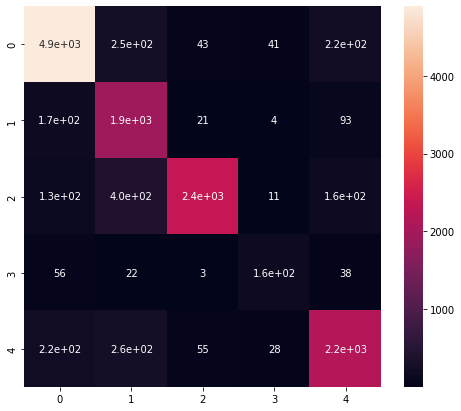

In [6]:
df = pd.read_csv("two_data_2yr.csv")
df['X'] = df['X'].astype(str)

list_of_words = []
for i in df.X:
    for j in i:
        list_of_words.append(j)
total_words = len(list(set(list_of_words)))
print(total_words)

x_train, x_test, y_train, y_test = train_test_split(df.X, df.Y, test_size = 0.2, random_state=1000)

# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Adding Padding
padded_train = pad_sequences(train_sequences,maxlen = 150, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 150, truncating = 'post')

embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

# Sequential Model
model = Sequential()

# Embeddidng layer
vocab_size = len(tokenizer.word_index) + 1
maxlen = 150
model.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

# Bi-Directional RNN and LSTM
model.add(LSTM(128, return_sequences= True ))
model.add(LSTM(64, return_sequences=False))
# Dense layers
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)
y_train = np.squeeze(y_train, axis=None)
# Training the model

history = model.fit(padded_train, y_train,
                    epochs=70,
                    validation_split = 0.1,
                    batch_size=256)


prediction = model.predict(padded_test)
prediction=np.argmax(prediction,axis=1)
# Getting The Accuracy
from sklearn.metrics import accuracy_score, f1_score

F1_score = f1_score(list(y_test), prediction,average='micro')
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)
print("Model F1 : ", F1_score)

#Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8, 7))
sns.heatmap(cm, annot = True)

file_list=['gun','police','covid','vaccine','election_fraud','gun_5yr','police_5yr',
           'covid_5yr','vaccine_5yr','election_fraud_5yr']
# 'one_data_1yr','two_data_2yr'
for i in file_list:
    df = pd.read_csv("{}.csv".format(i))
    x_test = df['X'].to_list()
    y_test = df['Y'].to_list()
    test_sequences = tokenizer.texts_to_sequences(x_test)
    padded_test = pad_sequences(test_sequences,maxlen = 150, truncating = 'post')
    prediction = model.predict(padded_test)
    prediction = np.argmax(prediction,axis=1)
#     F1_score = f1_score(list(y_test), prediction,average='micro')
    accuracy = accuracy_score(list(y_test), prediction)
    print("Test on {} Accuracy: ".format(i), accuracy)

317
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 50)           8854100   
                                                                 
 lstm_6 (LSTM)               (None, 150, 128)          91648     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 8,997,401
Trainable params: 143,301
Non-trainable params: 8,854,100
_________________________________________________________________
Epoch 1/70
141/141 [==============

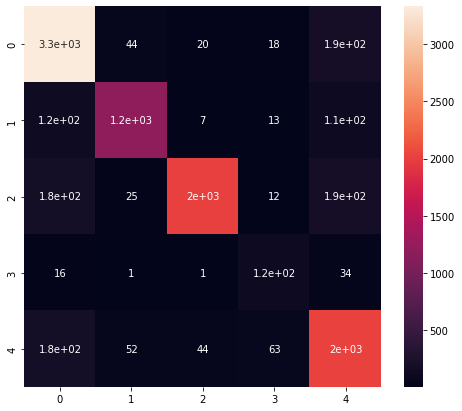

In [7]:
df = pd.read_csv("one_data_1yr.csv")
df['X'] = df['X'].astype(str)

list_of_words = []
for i in df.X:
    for j in i:
        list_of_words.append(j)
total_words = len(list(set(list_of_words)))
print(total_words)

x_train, x_test, y_train, y_test = train_test_split(df.X, df.Y, test_size = 0.2, random_state=1000)

# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Adding Padding
padded_train = pad_sequences(train_sequences,maxlen = 150, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 150, truncating = 'post')

embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

# Sequential Model
model = Sequential()

# Embeddidng layer
vocab_size = len(tokenizer.word_index) + 1
maxlen = 150
model.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

# Bi-Directional RNN and LSTM
model.add(LSTM(128, return_sequences= True ))
model.add(LSTM(64, return_sequences=False))
# Dense layers
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)
y_train = np.squeeze(y_train, axis=None)
# Training the model

history = model.fit(padded_train, y_train,
                    epochs=70,
                    validation_split = 0.1,
                    batch_size=256)


prediction = model.predict(padded_test)
prediction=np.argmax(prediction,axis=1)
# Getting The Accuracy
from sklearn.metrics import accuracy_score, f1_score

F1_score = f1_score(list(y_test), prediction,average='micro')
accuracy = accuracy_score(list(y_test), prediction)

print("Model Accuracy : ", accuracy)
print("Model F1 : ", F1_score)

#Getting The Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (8, 7))
sns.heatmap(cm, annot = True)

file_list=['gun','police','covid','vaccine','election_fraud','gun_5yr','police_5yr',
           'covid_5yr','vaccine_5yr','election_fraud_5yr']
# 'one_data_1yr','two_data_2yr'
for i in file_list:
    df = pd.read_csv("{}.csv".format(i))
    x_test = df['X'].to_list()
    y_test = df['Y'].to_list()
    test_sequences = tokenizer.texts_to_sequences(x_test)
    padded_test = pad_sequences(test_sequences,maxlen = 150, truncating = 'post')
    prediction = model.predict(padded_test)
    prediction = np.argmax(prediction,axis=1)
#     F1_score = f1_score(list(y_test), prediction,average='micro')
    accuracy = accuracy_score(list(y_test), prediction)
    print("Test on {} Accuracy: ".format(i), accuracy)